In [1]:
# !wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
# !bash install_colab.sh

In [1]:
from fastai.vision.all import *

In [2]:
from icevision.all import *

# Loading dataset

In [3]:
# path of dataset
data_dir = Path('./nikelogos')

# Create the parser
parser = parsers.VOCBBoxParser(annotations_dir=data_dir / "annotations", images_dir=data_dir / "images")
parser.class_map


# Parse annotations to create records
train_records, valid_records = parser.parse()

# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize(), tfms.A.Rotate()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

len(train_ds), len(valid_ds)

INFO     - Autofixing records | icevision.parsers.parser:parse:136


WARNING  - (record_id: 340) - 🚫 Record could not be autofixed and will be removed because: File 'nikelogos/images/nike_logo_tshirt_362.jpg' does not exist | icevision.core.record:autofix_records:100


WARNING  - (record_id: 250) - 🚫 Record could not be autofixed and will be removed because: File 'nikelogos/images/nike_logo_shoes_528.jpg' does not exist | icevision.core.record:autofix_records:100


(405, 101)

# Making model

In [4]:
# Just change the value of selection to try different modeles

selection = 1 # !!! Zero will lead to error in loading model for inference  


extra_args = {}

if selection == 0:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x

elif selection == 1:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.retinanet
  backbone = model_type.backbones.resnet50_fpn

elif selection == 2:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_lite0
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 3:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.small
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = image_size

model = model_type.model(backbone=backbone(pretrained=True),num_classes=len(parser.class_map), **extra_args)


# Making dataloader

In [5]:
train_dl = model_type.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

# Training the model

In [6]:
# defining metric and learner fro training
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]
learner1 = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)


## Step0 - Freeze with wd

In [26]:
learner1.freeze() # freeze the already trained part of the model. 

 lr_min_10,lr_steep:  1.9054606673307718e-05 6.309573450380412e-07


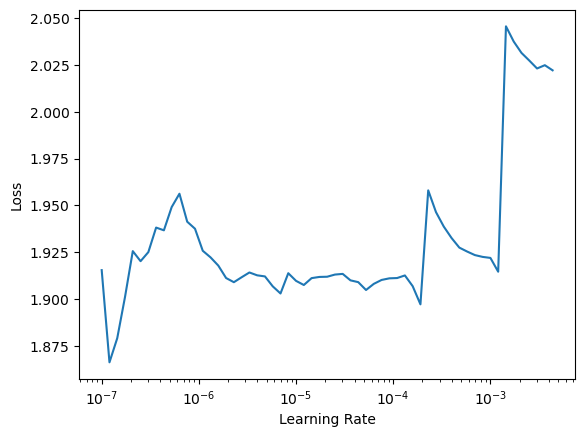

In [27]:
# check output of learning rate finder and set the initial learning rate
lr_min_10, lr_steep = learner1.lr_find(start_lr=1e-7, end_lr=10, num_it=100, stop_div=True, show_plot=True, suggestions=True)
print(" lr_min_10,lr_steep: ",lr_min_10,lr_steep)

In [28]:
# lr0 = lr_min_10
lr0 = 1e-4 # model 1
# lr0 = 0.014 # model 3
lr0

0.0001

epoch,train_loss,valid_loss,COCOMetric,time
0,1.706707,1.611339,0.002627,00:15
1,1.534613,1.584235,0.003769,00:15
2,1.441526,1.464582,0.004284,00:15
3,1.370751,1.395874,0.008869,00:15
4,1.312719,1.383017,0.011935,00:15
5,1.278289,1.416694,0.014421,00:15
6,1.248878,1.281549,0.022881,00:15
7,1.211968,1.294231,0.034240,00:14
8,1.184978,1.231507,0.034987,00:15
9,1.162002,1.250749,0.050480,00:15


Better model found at epoch 0 with valid_loss value: 1.6113394498825073.


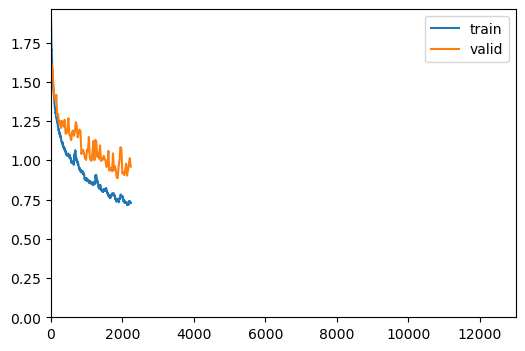

Better model found at epoch 1 with valid_loss value: 1.584235429763794.
Better model found at epoch 2 with valid_loss value: 1.464582085609436.
Better model found at epoch 3 with valid_loss value: 1.3958739042282104.
Better model found at epoch 4 with valid_loss value: 1.3830167055130005.
Better model found at epoch 6 with valid_loss value: 1.2815489768981934.
Better model found at epoch 8 with valid_loss value: 1.2315067052841187.
Better model found at epoch 10 with valid_loss value: 1.2058650255203247.
Better model found at epoch 15 with valid_loss value: 1.1696511507034302.
Better model found at epoch 19 with valid_loss value: 1.164007544517517.
Better model found at epoch 20 with valid_loss value: 1.155097484588623.
Better model found at epoch 21 with valid_loss value: 1.1280077695846558.
Better model found at epoch 32 with valid_loss value: 1.0405031442642212.
Better model found at epoch 35 with valid_loss value: 1.0374706983566284.
Better model found at epoch 36 with valid_loss v

In [29]:
# defining callbacks to control the process of training (see indivitual comments below)
fname=f"model_{selection}_step0_log.csv"
cbs = [ EarlyStoppingCallback(patience=15) # if valid_loss does not drop in "patience" steps, stop training early
        , SaveModelCallback() # save model at best valid_loss and load at the end of training 
        , ShowGraphCallback() # show a graph of train_loss and Valis_loss
        , CSVLogger(fname=fname)] # save losses for each step to disk

# train the frozen model with cbs conditions (for cbs details see above)
learner1.fit(500, lr0, cbs=cbs, wd=0.2) 

# saving model to file at the end of training
PATH = f"model_{selection}_step0.m"
torch.save(model.state_dict(), PATH)

## Step1 - unfreeze with wd

In [7]:
# load frozen training result from previous part
PATH = f"model_{selection}_step0.m"
device = torch.device('cuda')
model.load_state_dict(torch.load(PATH, map_location=device))



<All keys matched successfully>

In [8]:
# unfreeze the learner to optimize all the weights
learner1.unfreeze()

 lr_min_10,lr_steep:  5.248074558039662e-07 9.120108046545283e-08


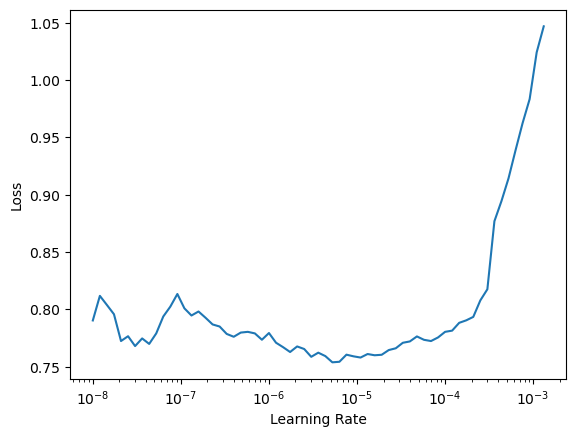

In [9]:
# check out put of learning rate finder
lr_min_10,lr_steep = learner1.lr_find(start_lr=1e-8, end_lr=1, num_it=100, stop_div=True, show_plot=True, suggestions=True)
print(" lr_min_10,lr_steep: ",lr_min_10,lr_steep)

In [10]:
# lr1 = lr_min_10
# lr1 = lr0/10 # normally at this step output of lr_find is not informative. Just use lr of 10 times smaller than lr0. 
lr1= 1e-5 # model 1
# lr1= 1e-4 # model 3
lr1

1e-05

epoch,train_loss,valid_loss,COCOMetric,time
0,0.763937,0.724244,0.260140,00:22
1,0.738515,0.704311,0.255286,00:22
2,0.735589,0.756606,0.199499,00:22
3,0.727247,0.690832,0.269942,00:22
4,0.705480,0.709659,0.249203,00:22
5,0.684809,0.697338,0.261088,00:22
6,0.671210,0.668552,0.264716,00:22
7,0.668016,0.652596,0.276977,00:22
8,0.661009,0.678149,0.291079,00:21
9,0.649280,0.654528,0.301161,00:22


Better model found at epoch 0 with valid_loss value: 0.724243700504303.


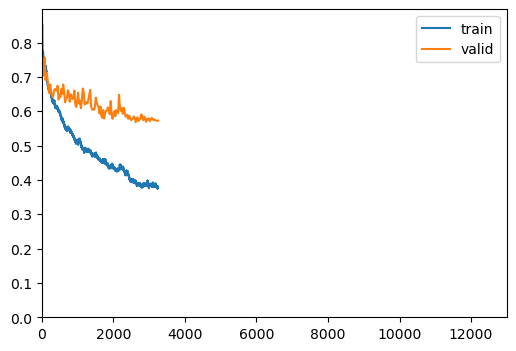

Better model found at epoch 1 with valid_loss value: 0.7043105959892273.
Better model found at epoch 3 with valid_loss value: 0.6908315420150757.
Better model found at epoch 6 with valid_loss value: 0.6685524582862854.
Better model found at epoch 7 with valid_loss value: 0.6525960564613342.
Better model found at epoch 10 with valid_loss value: 0.643667459487915.
Better model found at epoch 11 with valid_loss value: 0.6413248181343079.
Better model found at epoch 17 with valid_loss value: 0.6342014074325562.
Better model found at epoch 24 with valid_loss value: 0.6259686350822449.
Better model found at epoch 35 with valid_loss value: 0.6201619505882263.
Better model found at epoch 36 with valid_loss value: 0.6123654246330261.
Better model found at epoch 41 with valid_loss value: 0.6089373230934143.
Better model found at epoch 53 with valid_loss value: 0.6048802733421326.
Better model found at epoch 55 with valid_loss value: 0.6042254567146301.
Better model found at epoch 61 with valid_l

In [11]:
# defining callbacks to control the process of training (see indivitual comments below)
fname=f"model_{selection}_step1_log.csv"
cbs = [   ReduceLROnPlateau(patience=15, factor=6.0) # if valid_loss does not drop in "patience" steps, drop lr by factor of 10
        , EarlyStoppingCallback(patience=25) # if valid_loss does not drop in "patience" steps, stop training early
        , SaveModelCallback() # save model at best valid_loss and load at the end of training 
        , ShowGraphCallback() # show a graph of train_loss and Valis_loss
        , CSVLogger(fname=fname)] # save losses for each step to disk

# train the whole model with cbs conditions (for cbs details see above)
learner1.fit(500, lr1, cbs=cbs, wd=0.2)

# saving model to file at the end of training
PATH = f"model_{selection}_step1.m"
torch.save(model.state_dict(), PATH)

## Step2 - unfreeze without wd

In [12]:
# load frozen training result from previous part
PATH = f"model_{selection}_step1.m"
device = torch.device('cuda')
model.load_state_dict(torch.load(PATH, map_location=device))



<All keys matched successfully>

 lr_min_10,lr_steep:  9.120108046545284e-09 6.309573308271865e-08


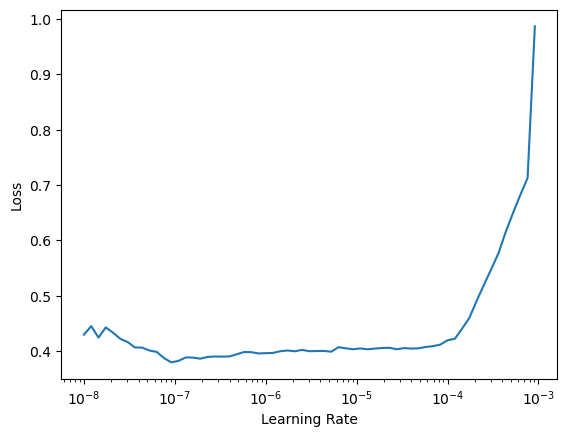

In [13]:
# unfreeze the learner to optimize all the weights

# check out put of learning rate finder
lr_min_10,lr_steep = learner1.lr_find(start_lr=1e-8, end_lr=1, num_it=100, stop_div=True, show_plot=True, suggestions=True)
print(" lr_min_10,lr_steep: ",lr_min_10,lr_steep)


In [14]:
# lr2 = lr_min_10
# lr2 = lr0/10 # normally at this step output of lr_find is not informative. Just use lr of 10 times smaller than lr0. 
lr2 = 1e-4 # model 1
# lr2 = 1e-4 # model 3
lr2

0.0001

epoch,train_loss,valid_loss,COCOMetric,time
0,0.875183,1.029918,0.158198,00:22
1,0.814016,0.771845,0.291009,00:22
2,0.753857,0.814294,0.247779,00:21
3,0.770452,0.843492,0.180054,00:22
4,0.738561,0.857973,0.256984,00:21
5,0.731442,0.732942,0.260607,00:21
6,0.715602,0.739562,0.270600,00:22
7,0.707510,0.699034,0.267382,00:22
8,0.682927,0.709647,0.256096,00:22
9,0.649276,0.712604,0.272737,00:22


Better model found at epoch 0 with valid_loss value: 1.0299183130264282.


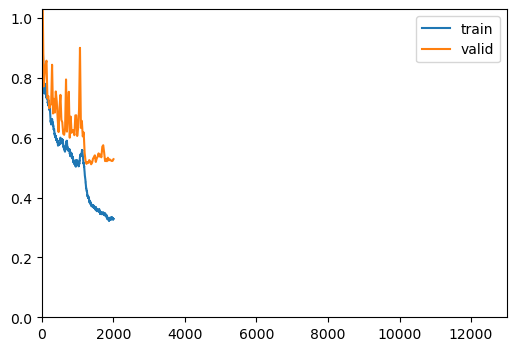

Better model found at epoch 1 with valid_loss value: 0.7718446850776672.
Better model found at epoch 5 with valid_loss value: 0.732941746711731.
Better model found at epoch 7 with valid_loss value: 0.6990342736244202.
Better model found at epoch 11 with valid_loss value: 0.6815060973167419.
Better model found at epoch 16 with valid_loss value: 0.665345311164856.
Better model found at epoch 17 with valid_loss value: 0.6194077134132385.
Better model found at epoch 22 with valid_loss value: 0.6135615110397339.
Better model found at epoch 23 with valid_loss value: 0.6102195382118225.
Better model found at epoch 29 with valid_loss value: 0.6005409359931946.
Epoch 44: reducing lr to 1.6666666666666667e-05
Better model found at epoch 45 with valid_loss value: 0.5500889420509338.
Better model found at epoch 46 with valid_loss value: 0.5220376253128052.
Better model found at epoch 47 with valid_loss value: 0.5129584670066833.
Better model found at epoch 52 with valid_loss value: 0.5116428136825

In [15]:
# defining callbacks to control the process of training (see indivitual comments below)
fname=f"model_{selection}_step2_log.csv"
cbs = [   ReduceLROnPlateau(patience=15, factor=6.0) # if valid_loss does not drop in "patience" steps, drop lr by factor of 10
        , EarlyStoppingCallback(patience=25) # if valid_loss does not drop in "patience" steps, stop training early
        , SaveModelCallback() # save model at best valid_loss and load at the end of training 
        , ShowGraphCallback() # show a graph of train_loss and Valis_loss
        , CSVLogger(fname=fname)] # save losses for each step to disk

# train the whole model with cbs conditions (for cbs details see above)
learner1.fit(500, lr2, cbs=cbs)

# saving model to file at the end of training
PATH = f"model_{selection}_step2_final.m"
torch.save(model.state_dict(), PATH)